# Live Training: Quadrotor Hover with SAC

This notebook trains a SAC policy on the `QuadrotorHover-v0` environment with **live visualization** of:
- Episode reward & length curves
- 3D quadrotor trajectory during evaluation
- Position error convergence
- Motor command distribution

**Requirements:** `pip install -e ".[train,sim]"` + `pip install ipykernel ipywidgets matplotlib`

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 — needed for 3D projection
from stable_baselines3 import SAC
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.monitor import Monitor

from training.envs.config import HoverEnvConfig
from training.scripts.train_hover import count_actor_params, make_env

warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib widget
print("All imports successful.")

All imports successful.


## 1. Create Environment & Model

In [2]:
# --- Configuration ---
TOTAL_TIMESTEPS = 200_000   # Adjust for longer/shorter training
EVAL_INTERVAL = 2_000       # Steps between live plot updates
SEED = 42

# Load env config (uses defaults — hover at [0,0,1])
env_config = HoverEnvConfig.default()
env_config.max_episode_time = 15.0  # Shorter episodes for faster iteration

# Training environment
train_env = make_vec_env(
    lambda: Monitor(make_env(env_config, seed=SEED)),
    n_envs=1,
    seed=SEED,
)

# Separate eval environment (no domain randomization)
eval_env = make_env(env_config, seed=SEED + 1000, eval_mode=True)

# SAC with 2x128 MLP (RL007/RL008)
model = SAC(
    "MlpPolicy",
    train_env,
    policy_kwargs={"net_arch": [128, 128]},
    learning_rate=3e-4,
    batch_size=256,
    buffer_size=100_000,
    learning_starts=500,
    tau=0.005,
    gamma=0.99,
    ent_coef="auto",
    seed=SEED,
    verbose=0,
)

actor_params = count_actor_params(model)
print(f"Actor parameters: {actor_params} (RL008 limit: 19,076)")
print(f"Observation space: {train_env.observation_space}")
print(f"Action space:      {train_env.action_space}")
print(f"Episode length:    {env_config.max_episode_time}s at {env_config.control_freq}Hz = {int(env_config.max_episode_time * env_config.control_freq)} steps")

Actor parameters: 19592 (RL008 limit: 19,076)
Observation space: Box(-1.0, 1.0, (15,), float32)
Action space:      Box(-1.0, 1.0, (4,), float32)
Episode length:    15.0s at 50Hz = 750 steps


## 2. Live Visualization Callback

Custom SB3 callback that updates a 4-panel matplotlib figure during training:
- **Top-left:** Episode reward over time
- **Top-right:** 3D trajectory of latest eval episode
- **Bottom-left:** Position error convergence
- **Bottom-right:** Motor speed distribution

In [3]:
class LivePlotCallback(BaseCallback):
    """SB3 callback that renders live training dashboards in Jupyter."""

    def __init__(self, eval_env, eval_freq=2000, n_eval_steps=500, verbose=0):
        super().__init__(verbose)
        self.eval_env = eval_env
        self.eval_freq = eval_freq
        self.n_eval_steps = n_eval_steps

        # Accumulated data
        self.ep_rewards = []
        self.ep_lengths = []
        self.ep_pos_errors = []
        self.timesteps_log = []

        # Latest eval trajectory
        self.traj_positions = []
        self.traj_motor_speeds = []
        self.traj_goal = np.array([0, 0, 1.0])

        # Figure setup
        self.fig = plt.figure(figsize=(14, 9))
        gs = GridSpec(2, 2, figure=self.fig, hspace=0.35, wspace=0.3)

        # Panel 1: episode reward
        self.ax_reward = self.fig.add_subplot(gs[0, 0])
        self.ax_reward.set_xlabel("Timestep")
        self.ax_reward.set_ylabel("Episode Reward")
        self.ax_reward.set_title("Training Reward")
        self.ax_reward.grid(True, alpha=0.3)

        # Panel 2: 3D trajectory
        self.ax_3d = self.fig.add_subplot(gs[0, 1], projection="3d")
        self.ax_3d.set_xlabel("X (m)")
        self.ax_3d.set_ylabel("Y (m)")
        self.ax_3d.set_zlabel("Z (m)")
        self.ax_3d.set_title("Eval Trajectory")

        # Panel 3: position error
        self.ax_pos_err = self.fig.add_subplot(gs[1, 0])
        self.ax_pos_err.set_xlabel("Timestep")
        self.ax_pos_err.set_ylabel("Position Error (m)")
        self.ax_pos_err.set_title("Final Position Error")
        self.ax_pos_err.grid(True, alpha=0.3)

        # Panel 4: motor speeds
        self.ax_motors = self.fig.add_subplot(gs[1, 1])
        self.ax_motors.set_xlabel("Step in Episode")
        self.ax_motors.set_ylabel("Motor Speed (rad/s)")
        self.ax_motors.set_title("Motor Commands (Eval)")
        self.ax_motors.grid(True, alpha=0.3)

        self.fig.suptitle("Quadrotor Hover — SAC Training", fontsize=14, fontweight="bold")
        plt.tight_layout()
        display(self.fig)

    def _on_step(self) -> bool:
        # Collect episode stats from Monitor wrapper
        infos = self.locals.get("infos", [])
        for info in infos:
            ep = info.get("episode")
            if ep is not None:
                self.ep_rewards.append(float(ep["r"]))
                self.ep_lengths.append(int(ep["l"]))
                self.timesteps_log.append(self.num_timesteps)
                pos = info.get("position")
                goal = info.get("goal")
                if pos is not None and goal is not None:
                    self.ep_pos_errors.append(float(np.linalg.norm(
                        np.array(goal) - np.array(pos)
                    )))

        # Periodic evaluation + plot update
        if self.num_timesteps % self.eval_freq == 0:
            self._run_eval()
            self._update_plots()
        return True

    def _run_eval(self):
        """Roll out the current policy on eval_env and record trajectory."""
        obs, info = self.eval_env.reset(seed=99)
        self.traj_positions = [info["position"].copy()]
        self.traj_motor_speeds = []
        self.traj_goal = info["goal"].copy()

        for _ in range(self.n_eval_steps):
            action, _ = self.model.predict(obs, deterministic=True)
            obs, _reward, terminated, truncated, info = self.eval_env.step(action)
            self.traj_positions.append(info["position"].copy())
            self.traj_motor_speeds.append(info["motor_speeds"].copy())
            if terminated or truncated:
                break

    def _update_plots(self):
        """Redraw all four panels."""
        # --- Panel 1: Reward curve ---
        self.ax_reward.clear()
        self.ax_reward.set_xlabel("Timestep")
        self.ax_reward.set_ylabel("Episode Reward")
        self.ax_reward.set_title("Training Reward")
        self.ax_reward.grid(True, alpha=0.3)
        if self.ep_rewards:
            self.ax_reward.plot(self.timesteps_log, self.ep_rewards, "b.", alpha=0.3, markersize=2)
            # Running average
            if len(self.ep_rewards) >= 10:
                window = min(50, len(self.ep_rewards))
                avg = np.convolve(self.ep_rewards, np.ones(window) / window, mode="valid")
                offset = window - 1
                self.ax_reward.plot(
                    self.timesteps_log[offset:], avg, "r-", linewidth=2, label=f"MA({window})"
                )
                self.ax_reward.legend(loc="lower right", fontsize=8)

        # --- Panel 2: 3D trajectory ---
        self.ax_3d.clear()
        self.ax_3d.set_xlabel("X (m)")
        self.ax_3d.set_ylabel("Y (m)")
        self.ax_3d.set_zlabel("Z (m)")
        self.ax_3d.set_title(f"Eval Trajectory ({len(self.traj_positions)} steps)")
        if self.traj_positions:
            pos = np.array(self.traj_positions)
            self.ax_3d.plot3D(pos[:, 0], pos[:, 1], pos[:, 2], "b-", linewidth=1)
            self.ax_3d.scatter(*pos[0], color="green", s=60, label="Start", zorder=5)
            self.ax_3d.scatter(*pos[-1], color="red", s=60, label="End", zorder=5)
            g = self.traj_goal
            self.ax_3d.scatter(*g, color="gold", s=100, marker="*", label="Goal", zorder=5)
            # Set symmetric limits around goal
            max_range = max(
                np.ptp(pos[:, 0]), np.ptp(pos[:, 1]), np.ptp(pos[:, 2]), 0.5
            ) * 0.6
            setters = [self.ax_3d.set_xlim, self.ax_3d.set_ylim, self.ax_3d.set_zlim]
            for dim in range(3):
                center = g[dim]
                setters[dim](center - max_range, center + max_range)
            self.ax_3d.legend(loc="upper left", fontsize=7)

        # --- Panel 3: Position error ---
        self.ax_pos_err.clear()
        self.ax_pos_err.set_xlabel("Timestep")
        self.ax_pos_err.set_ylabel("Position Error (m)")
        self.ax_pos_err.set_title("Final Position Error")
        self.ax_pos_err.grid(True, alpha=0.3)
        if self.ep_pos_errors:
            self.ax_pos_err.plot(
                self.timesteps_log[:len(self.ep_pos_errors)],
                self.ep_pos_errors, "g.", alpha=0.3, markersize=2
            )
            if len(self.ep_pos_errors) >= 10:
                window = min(50, len(self.ep_pos_errors))
                avg = np.convolve(self.ep_pos_errors, np.ones(window) / window, mode="valid")
                offset = window - 1
                self.ax_pos_err.plot(
                    self.timesteps_log[offset:offset + len(avg)],
                    avg, "darkgreen", linewidth=2, label=f"MA({window})"
                )
                self.ax_pos_err.legend(loc="upper right", fontsize=8)

        # --- Panel 4: Motor speeds ---
        self.ax_motors.clear()
        self.ax_motors.set_xlabel("Step in Episode")
        self.ax_motors.set_ylabel("Motor Speed (rad/s)")
        self.ax_motors.set_title("Motor Commands (Eval)")
        self.ax_motors.grid(True, alpha=0.3)
        if self.traj_motor_speeds:
            speeds = np.array(self.traj_motor_speeds)
            motor_labels = ["M0 (FR,CCW)", "M1 (FL,CW)", "M2 (RL,CCW)", "M3 (RR,CW)"]
            colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]
            for i in range(4):
                self.ax_motors.plot(speeds[:, i], color=colors[i], label=motor_labels[i], linewidth=1)
            # Hover reference line
            hover_speed = 535.6
            self.ax_motors.axhline(hover_speed, color="gray", linestyle="--", alpha=0.5, label="Hover")
            self.ax_motors.set_ylim(0, 850)
            self.ax_motors.legend(loc="upper right", fontsize=7, ncol=2)

        self.fig.canvas.draw_idle()
        self.fig.canvas.flush_events()

print("LivePlotCallback defined.")

LivePlotCallback defined.


## 3. Train with Live Dashboard

Run the cell below to start training. The 4-panel plot will update every `EVAL_INTERVAL` timesteps:

| Panel | What it shows |
|-------|---------------|
| Top-left | Episode reward (blue dots) + moving average (red line) |
| Top-right | 3D flight path from latest eval rollout (green=start, red=end, star=goal) |
| Bottom-left | Position error at episode end — should decrease over time |
| Bottom-right | Motor speeds during eval — should converge near ~535 rad/s (hover) |

/tmp/ipykernel_5638/2518866640.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


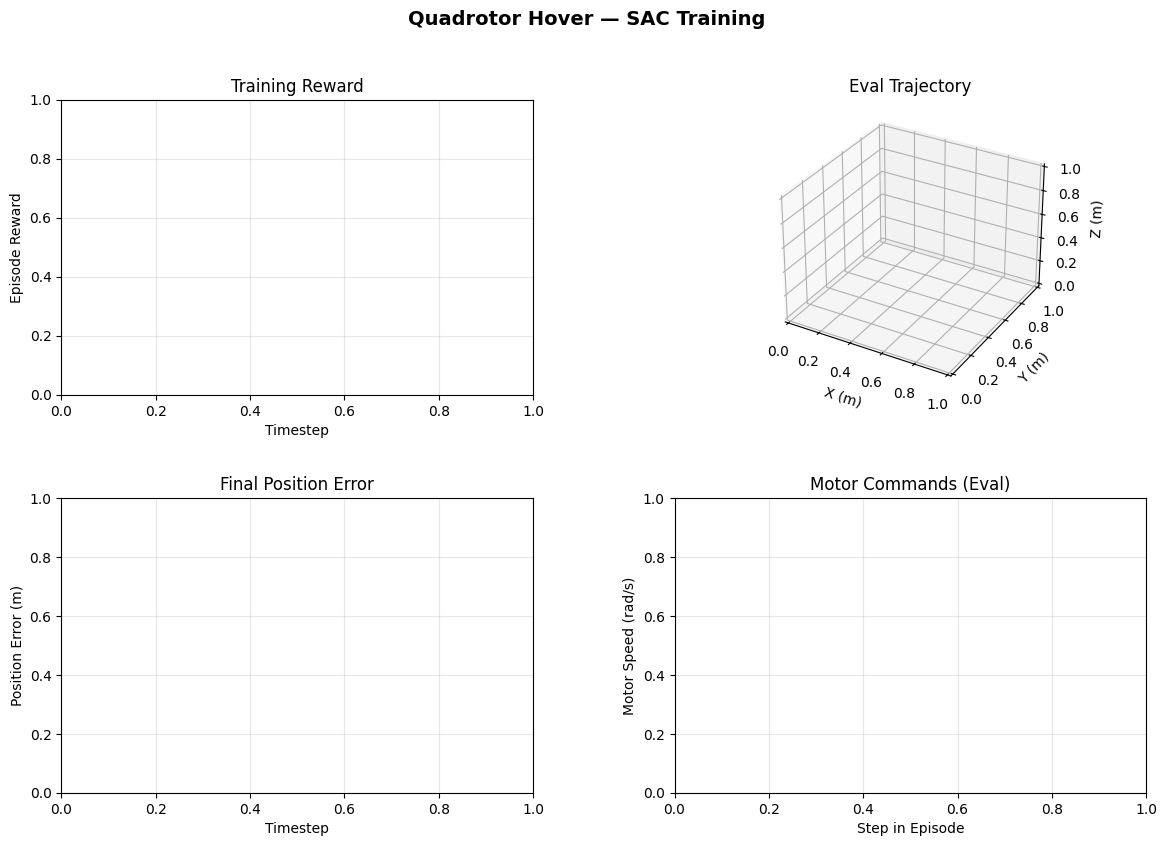

Output()

Starting SAC training for 200,000 timesteps...
Live plot updates every 2,000 steps.



In [ ]:
live_cb = LivePlotCallback(
    eval_env=eval_env,
    eval_freq=EVAL_INTERVAL,
    n_eval_steps=int(env_config.max_episode_time * env_config.control_freq),  # full episode
)

print(f"Starting SAC training for {TOTAL_TIMESTEPS:,} timesteps...")
print(f"Live plot updates every {EVAL_INTERVAL:,} steps.\n")

model.learn(total_timesteps=TOTAL_TIMESTEPS, callback=live_cb, progress_bar=True)

print(f"\nTraining complete! {len(live_cb.ep_rewards)} episodes collected.")
if live_cb.ep_rewards:
    last_50 = live_cb.ep_rewards[-50:]
    print(f"Last 50 episodes — reward: {np.mean(last_50):.1f} +/- {np.std(last_50):.1f}")

## 4. Post-Training Evaluation

Run the trained policy for a full episode and visualize the final trajectory with detailed telemetry.

In [ ]:
# Run one full deterministic evaluation episode
obs, info = eval_env.reset(seed=123)
positions, velocities, eulers, motor_cmds, rewards_ep = [], [], [], [], []
goal = info["goal"]

max_steps = int(env_config.max_episode_time * env_config.control_freq)
for _step in range(max_steps):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = eval_env.step(action)
    positions.append(info["position"].copy())
    velocities.append(info["velocity"].copy())
    eulers.append(np.degrees(info["euler"]))
    motor_cmds.append(info["motor_speeds"].copy())
    rewards_ep.append(reward)
    if terminated or truncated:
        break

positions = np.array(positions)
velocities = np.array(velocities)
eulers = np.array(eulers)
motor_cmds = np.array(motor_cmds)
t = np.arange(len(positions)) / env_config.control_freq

print(f"Episode: {len(positions)} steps ({t[-1]:.1f}s)")
print(f"Total reward: {sum(rewards_ep):.1f}")
print(f"Final position: {positions[-1]}")
print(f"Final pos error: {np.linalg.norm(goal - positions[-1]):.4f} m")
print(f"Terminated: {terminated}, Truncated: {truncated}")

In [ ]:
# Detailed telemetry plots
fig2, axes = plt.subplots(2, 3, figsize=(16, 8))
fig2.suptitle("Post-Training Evaluation — Detailed Telemetry", fontsize=14, fontweight="bold")

# Position XYZ
ax = axes[0, 0]
for i, (label, color) in enumerate(zip(["X", "Y", "Z"], ["r", "g", "b"], strict=True)):
    ax.plot(t, positions[:, i], color=color, label=label)
    ax.axhline(goal[i], color=color, linestyle="--", alpha=0.4)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Position (m)")
ax.set_title("Position vs Goal")
ax.legend()
ax.grid(True, alpha=0.3)

# Velocity XYZ
ax = axes[0, 1]
for i, (label, color) in enumerate(zip(["Vx", "Vy", "Vz"], ["r", "g", "b"], strict=True)):
    ax.plot(t, velocities[:, i], color=color, label=label)
ax.axhline(0, color="gray", linestyle="--", alpha=0.4)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Velocity (m/s)")
ax.set_title("Velocity")
ax.legend()
ax.grid(True, alpha=0.3)

# Euler angles
ax = axes[0, 2]
for i, (label, color) in enumerate(zip(["Roll", "Pitch", "Yaw"], ["r", "g", "b"], strict=True)):
    ax.plot(t, eulers[:, i], color=color, label=label)
ax.axhline(0, color="gray", linestyle="--", alpha=0.4)
ax.axhline(45, color="red", linestyle=":", alpha=0.3, label="Tilt limit")
ax.axhline(-45, color="red", linestyle=":", alpha=0.3)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Angle (deg)")
ax.set_title("Attitude")
ax.legend(fontsize=7)
ax.grid(True, alpha=0.3)

# Motor speeds
ax = axes[1, 0]
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]
motor_labels = ["M0", "M1", "M2", "M3"]
for i in range(4):
    ax.plot(t, motor_cmds[:, i], color=colors[i], label=motor_labels[i])
ax.axhline(535.6, color="gray", linestyle="--", alpha=0.5, label="Hover")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Speed (rad/s)")
ax.set_title("Motor Commands")
ax.legend(fontsize=7)
ax.set_ylim(0, 850)
ax.grid(True, alpha=0.3)

# Position error over time
ax = axes[1, 1]
pos_err = np.linalg.norm(goal - positions, axis=1)
ax.plot(t, pos_err, "purple", linewidth=1.5)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Error (m)")
ax.set_title("Position Error")
ax.grid(True, alpha=0.3)

# 3D trajectory
ax = axes[1, 2]
ax.remove()
ax = fig2.add_subplot(2, 3, 6, projection="3d")
ax.plot3D(positions[:, 0], positions[:, 1], positions[:, 2], "b-", linewidth=1)
ax.scatter(*positions[0], color="green", s=50, label="Start")
ax.scatter(*positions[-1], color="red", s=50, label="End")
ax.scatter(*goal, color="gold", s=80, marker="*", label="Goal")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("3D Trajectory")
ax.legend(fontsize=7)

plt.tight_layout()
plt.show()

## 5. Save Model

In [ ]:
from pathlib import Path

save_dir = Path("training/models")
save_dir.mkdir(parents=True, exist_ok=True)

model.save(str(save_dir / "hover_notebook_final"))
print(f"Model saved to {save_dir / 'hover_notebook_final'}.zip")

# Cleanup
train_env.close()
print("Done!")